In [129]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import os
import matplotlib.pyplot as plt
from matplotlib import pylab
import emoji
import re

<IPython.core.display.Javascript object>

In [130]:
%config IPCompleter.greedy=True
%matplotlib inline
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [131]:
# Constants
curr_dir = ".."
train_file = os.path.join(curr_dir, "dataset", "train.csv")
test_file = os.path.join(curr_dir, "dataset", "test.csv")

<IPython.core.display.Javascript object>

In [132]:
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (16, 5),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.set_theme(style="darkgrid")

<IPython.core.display.Javascript object>

In [133]:
df = pd.read_csv(train_file)
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<IPython.core.display.Javascript object>

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


<IPython.core.display.Javascript object>

In [135]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

<IPython.core.display.Javascript object>

In [136]:
def plotBarGraph(data, labelx, labely, title, switch_axis=False):
    y = data.index.tolist()
    x = data.tolist()
    if switch_axis:
        x = data.index.tolist()
        y = data.tolist()
    sns.barplot(y=y, x=x)
    plt.title(title)
    plt.xlabel(labelx)
    plt.ylabel(labely)
    plt.show()

<IPython.core.display.Javascript object>

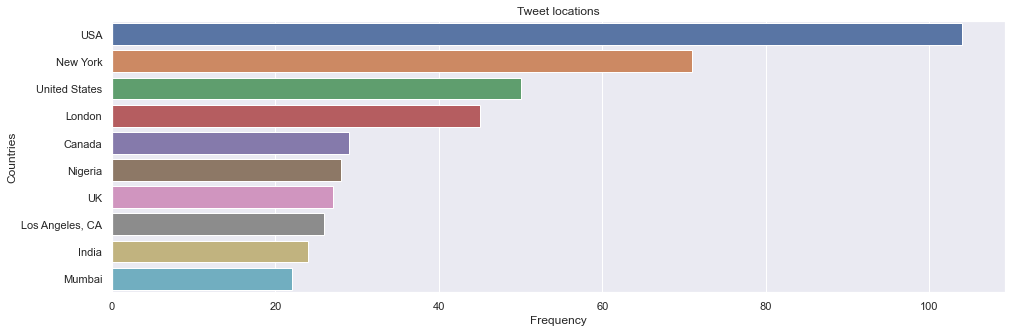

<IPython.core.display.Javascript object>

In [137]:
locations_map = df.location.value_counts().sort_values(ascending=False)[:10]
plotBarGraph(locations_map, "Frequency", "Countries", "Tweet locations")

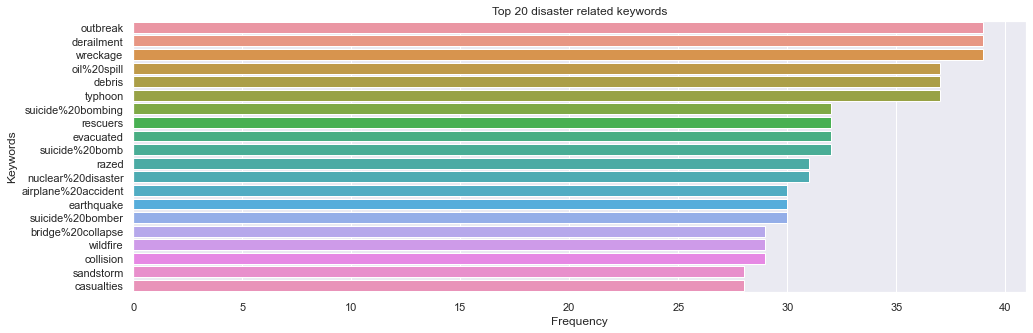

<IPython.core.display.Javascript object>

In [138]:
# Top 20 Disaster related Keywords
keywords_map = (
    df.keyword.loc[df.target == 1].value_counts().sort_values(ascending=False)[:20]
)
plotBarGraph(keywords_map, "Frequency", "Keywords", "Top 20 disaster related keywords")

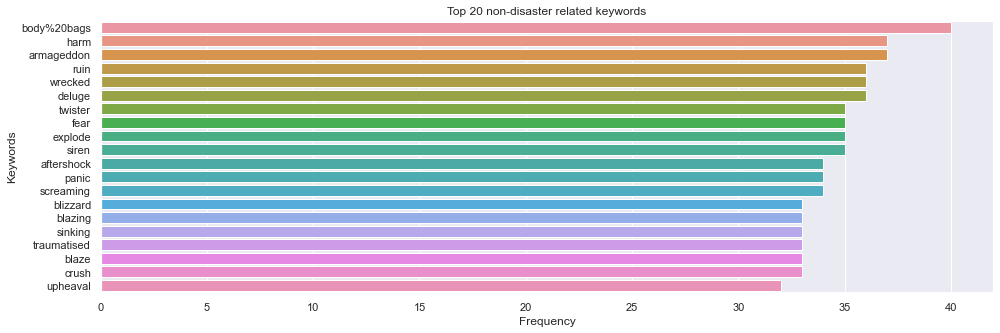

<IPython.core.display.Javascript object>

In [139]:
# Top 20 Non-Disaster related Keywords
keywords_non_disaster_map = df.keyword.loc[df.target == 0].value_counts(
    ascending=False
)[:20]
plotBarGraph(
    keywords_non_disaster_map,
    "Frequency",
    "Keywords",
    "Top 20 non-disaster related keywords",
)

In [140]:
print(
    "In the graphs(Top 20 disaster keywords and non-disaster keywords) above\n we see that disaster keywords are natural or artificial calamilites.\nWhile non-disaster keywords are too generalized keywords and not sufficient to describe a disaster."
)

In the graphs(Top 20 disaster keywords and non-disaster keywords) above
 we see that disaster keywords are natural or artificial calamilites.
While non-disaster keywords are too generalized keywords and not sufficient to describe a disaster.


<IPython.core.display.Javascript object>

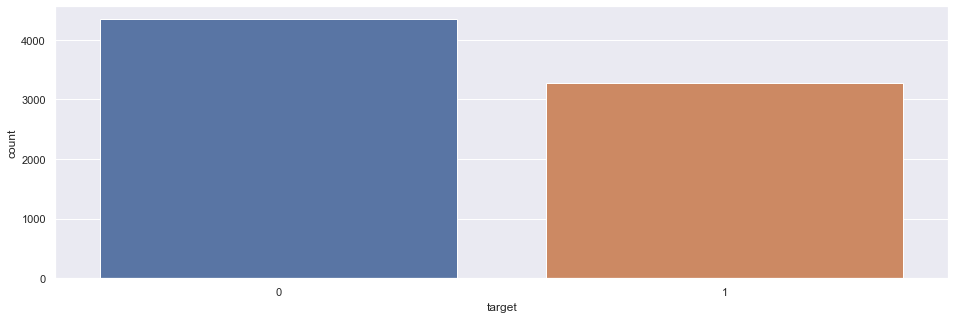

<IPython.core.display.Javascript object>

In [141]:
sns.countplot(x="target", data=df)
plt.show()

False    7503
True      110
Name: text, dtype: int64


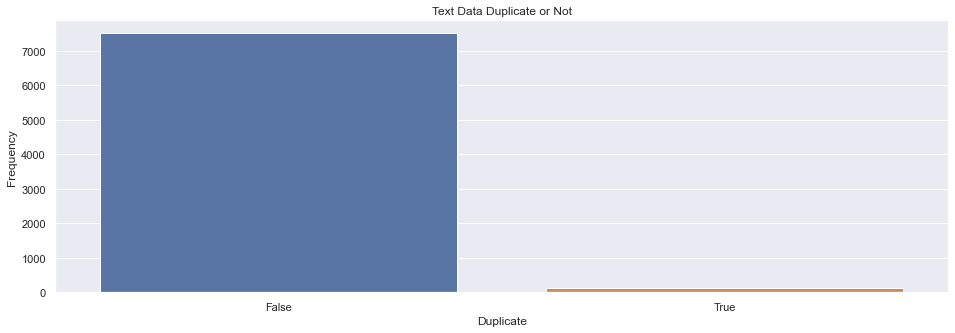

<IPython.core.display.Javascript object>

In [142]:
# Removing Duplicate Text Data
text_data_duplicate_map = df.text.duplicated().value_counts()
print(text_data_duplicate_map)
plotBarGraph(
    text_data_duplicate_map,
    "Duplicate",
    "Frequency",
    "Text Data Duplicate or Not",
    switch_axis=True,
)

In [143]:
print("Original dataframe shape: ", df.shape)
df.drop_duplicates(subset="text", keep="first", inplace=True)
print("Dropping duplicate rows and keeping original value shape: ", df.shape)
df.text.duplicated().value_counts()

Original dataframe shape:  (7613, 5)
Dropping duplicate rows and keeping original value shape:  (7503, 5)


False    7503
Name: text, dtype: int64

<IPython.core.display.Javascript object>

In [144]:
def search_text_data(query, column="text"):
    return df[df[column].str.contains(query)][column]


print(search_text_data("volcano")[:5])

1368    @POTUS Would you please explain what you are g...
3041    #SCSeEstaPreparando Light mag. 4.4 earthquake ...
4714    The sunset looked like an erupting volcano ......
6771    Maybe that's what happens when a tornado meets...
7126    Jetstar and Virgin forced to cancel Bali fligh...
Name: text, dtype: object


<IPython.core.display.Javascript object>

In [145]:
# Cleaning Text Data
def lower_case_data(data=""):
    data = data.lower()
    return data


df["clean_text"] = df["text"].apply(lower_case_data)
df["clean_text"]

0       our deeds are the reason of this #earthquake m...
1                  forest fire near la ronge sask. canada
2       all residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       just got sent this photo from ruby #alaska as ...
                              ...                        
7604    #worldnews fallen powerlines on g:link tram: u...
7605    on the flip side i'm at walmart and there is a...
7606    suicide bomber kills 15 in saudi security site...
7608    two giant cranes holding a bridge collapse int...
7612    the latest: more homes razed by northern calif...
Name: clean_text, Length: 7503, dtype: object

<IPython.core.display.Javascript object>

In [146]:
# Handle Emojis
def print_sentences_with_emojis(texts):
    sentences = []
    for sentence in texts:
        has_emoji = bool(emoji.get_emoji_regexp().search(sentence))
        if has_emoji:
            sentences.append(sentence)
    if len(sentences) == 0:
        print("Sentences are clean and don't have emojis!")
    else:
        print("".join(sentences))


print_sentences_with_emojis(df.clean_text)

# Source: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
def clean_emojis(text):
    allchars = [str for str in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    clean_text = " ".join(
        [str for str in text.split() if not any(i in str for i in emoji_list)]
    )
    return clean_text

how missing jetûªs debris could have floated to rì©union - the new york times http://t.co/pnnunrnqjarì©union debris is almost surely from flight 370 officials say - new york times http://t.co/gyqlaoz3l2rì©union debris is almost surely from flight 370 officials say - new york times http://t.co/vfbw3nyo9l#love #food #fun malaysian prime minister najib razak confirmed that the aircraft debris found on rì©union isla...  http://t.co/fk1l4nozigexploring new worlds: three moments of an explosion by china miì©ville http://t.co/otrwz1t9sp http://t.co/xvlkfcvfx5@ladyfleur the example i used is even worse in that it's a cafì© trying to market itself w/hashtag hijacking.nside a dragon's belly. or an ice cave under
a volcano in kamchatka | photography by
å©daniel korzhonov
http://t.co/8t36hwgoqd#science now that a piece of wreckage from flight mh370 has been confirmed on rì©union island is it possible t...  http://t.co/uqva3dfbca#science now that a piece of wreckage from flight mh370 has been conf

<IPython.core.display.Javascript object>

In [147]:
# Clean Emojis
df["clean_text"] = df["clean_text"].apply(clean_emojis)
print_sentences_with_emojis(df.clean_text)

Sentences are clean and don't have emojis!


<IPython.core.display.Javascript object>

In [148]:
# Clean urls
def clean_urls(text):
    text = re.sub(r"https?://\S+", "", text)
    return text


print(
    "There are",
    len(search_text_data("https", "clean_text").tolist()),
    "sentences with urls",
)
df["clean_text"] = df["text"].apply(clean_urls)
print(
    "There are",
    len(search_text_data("https", "clean_text").tolist()),
    "sentences with urls",
)

There are 404 sentences with urls
There are 0 sentences with urls


<IPython.core.display.Javascript object>

In [ ]:
# Remove punctuation
